# SWIMmeR

In [15]:
library(igraph)
library(gplots)
library(colorRamps)
library(parallel)
library(plyr)
library(dplyr)

In [25]:
source("~/Documents/system_biology/network_bio/TESI/SWIMR/lib/swimlib.R")

## Importing data into our environment


We are importing data, specifically:
- a **data matrix**
- a list of _treatment_ samples
- a list of _control_ samples

Make sure that your lists match perfectly the names of the columns in the data matrix.

**If not**, feel free to add some cells to this notebook to make it so.

In [26]:
setwd("~/Documents/system_biology/network_bio/TESI/SWIM/project/sample_project/dataset/brca/")

In [27]:
matrix.filename <- "matrix/matrix_RNASeq.txt"
data.matrix <- read.table(matrix.filename, header = T, row.names = 1, check.names = F)

matrix.mirna.filename <- "matrix/matrix_miRNASeq.txt"
mirna.matrix <- read.table(matrix.mirna.filename, header = T, row.names = 1, check.names = F)

# INSERT HERE YOUR LIST OF SAMPLES FOR CONDITION A [Tumor]
list.condA.filename <- "list/list_RNASeq_Tumor.txt"
mirna.condA.filename <- "list/list_miRNASeq_Tumor.txt"

list.condA <- read.table(list.condA.filename, header = F)
mirna.condA <- read.table(mirna.condA.filename, header = F)

# INSERT HERE YOUR LIST OF SAMPLES FOR CONDITION B [Control]
list.condB.filename <- "list/list_RNASeq_Normal.txt"
mirna.condB.filename <- "list/list_miRNASeq_Normal.txt"

list.condB <- read.table(list.condB.filename, header = F)
mirna.condB <- read.table(mirna.condB.filename, header = F)

# removing samples not used in the analysis
data.matrix <- data.matrix[, rbind(list.condA, list.condB)[[1]]]
mirna.matrix <- mirna.matrix[, rbind(mirna.condA, mirna.condB)[[1]]]

In [28]:
# In this test case with BRCA data from TGCA, our columns match only by the first three series of codes
mrna.match <- regexec(pattern = '^\\w+-\\w+-\\w+-\\w+-\\w+', text = names(data.matrix))
mirna.match <- regexec(pattern = '^\\w+-\\w+-\\w+-\\w+-\\w+', text = names(mirna.matrix))

mrna.names <- unlist(regmatches(x = names(data.matrix), m = mrna.match))
mirna.names <- unlist(regmatches(x = names(data.matrix), m = mirna.match))

names(data.matrix) <- mrna.names
names(mirna.matrix) <- mirna.names

# we also want to modify names in conditions lists
list.condA <- as.data.frame(unlist(regmatches(x = list.condA[[1]], 
                                              m = regexec(pattern = '^\\w+-\\w+-\\w+-\\w+-\\w+', 
                                                          text = list.condA[[1]]))))
list.condB <- as.data.frame(unlist(regmatches(x = list.condB[[1]], 
                                              m = regexec(pattern = '^\\w+-\\w+-\\w+-\\w+-\\w+', 
                                                          text = list.condB[[1]]))))
mirna.condA <- as.data.frame(unlist(regmatches(x = mirna.condA[[1]], 
                                               m = regexec(pattern = '^\\w+-\\w+-\\w+-\\w+-\\w+', 
                                                           text = mirna.condA[[1]]))))
mirna.condB <- as.data.frame(unlist(regmatches(x = mirna.condB[[1]], 
                                               m = regexec(pattern = '^\\w+-\\w+-\\w+-\\w+-\\w+', 
                                                           text = mirna.condB[[1]]))))

## Pre-processing

We are now cleaning up our data so to make it easier to analyze.
We log-2 transform it, remove NAs and we set some defined thresholds for:
- the minimum amount of zeros required to pass the quality filter
- the quantile of the IQR distribution of each gene

In [29]:
# LOG-2 Transformation (if necessary)
data.matrix <- log2(data.matrix + 1)
mirna.matrix <- log2(mirna.matrix + 1)

# NAs cleanup
is.na(data.matrix) <- sapply(data.matrix, is.infinite)
data.matrix[is.na(data.matrix)] <- 0

is.na(mirna.matrix) <- sapply(mirna.matrix, is.infinite)
mirna.matrix[is.na(mirna.matrix)] <- 0

## cleaning up zeros and setting a threshold for IQR
# set a threshold for the minimum amount of zeros required to pass the quality filter
# (on a scale from 0 to 1, what is the maximum amount of zero values you want to see in each gene?)
zero.thresh <- 0.75
mirna.zero.thresh <- 0.75

# set a threshold for the quantile of the IQR distribution of each gene
# (on a scale from 0 to 1, what is the minimum variation you want to see in each gene?)
iqr.thresh <- 0.11
mirna.iqr.thresh <- 0.53

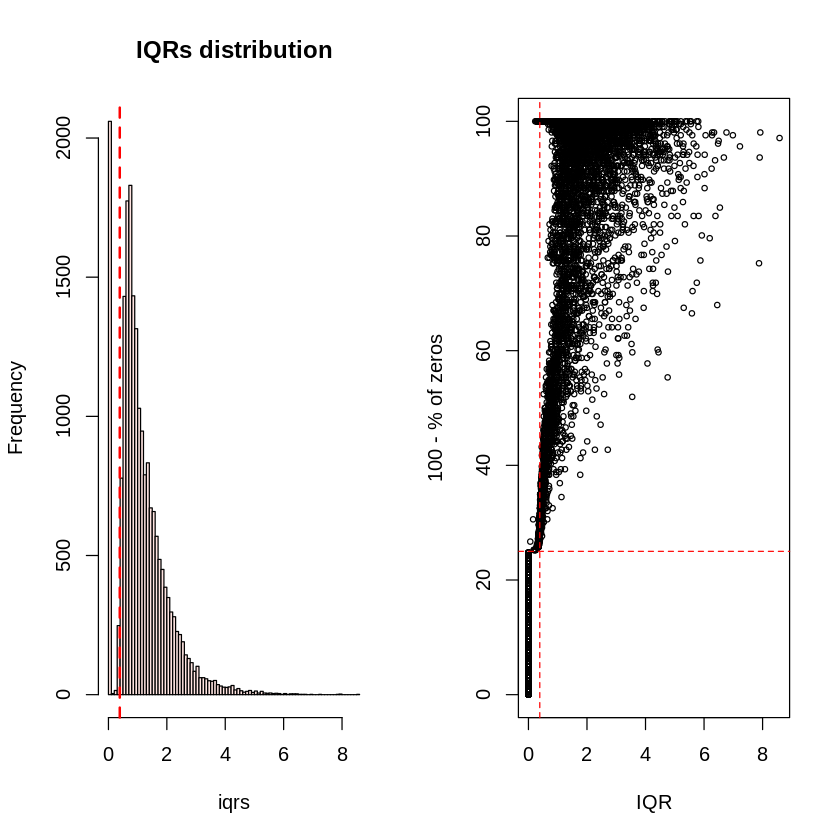

In [30]:
par(mfrow=c(1,2))
draw.iqr.dist(data.matrix, threshold = iqr.thresh)
draw.iqr.zeros(data.matrix, threshold.zeros = zero.thresh, threshold.iqr = iqr.thresh)

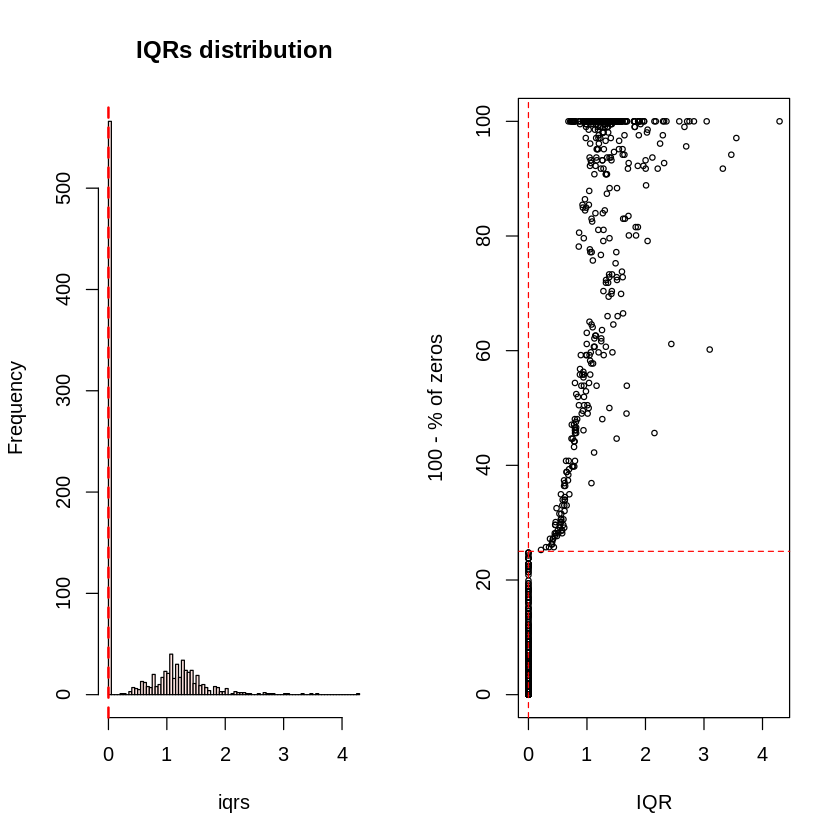

In [33]:
par(mfrow=c(1,2))
draw.iqr.dist(mirna.matrix, threshold = mirna.iqr.thresh)
draw.iqr.zeros(mirna.matrix, threshold.zeros = mirna.zero.thresh, threshold.iqr = mirna.iqr.thresh)

if we are happy with what we see, we can proceed to filtering, otherwise 
we can change values for our threshold and re-plot everything

In [ ]:
data.matrix <- clean.iqr(dataset = data.matrix, threshold = iqr.thresh)
data.matrix <- clean.zeros(dataset = data.matrix, threshold = zero.thresh)

In [ ]:
mirna.matrix <- clean.iqr(dataset = mirna.matrix, threshold = mirna.iqr.thresh)
mirna.matrix <- clean.zeros(dataset = mirna.matrix, threshold = mirna.zero.thresh)

## Filtering

Now, we need to filter all non-statistically significant genes. We will use a Student's t test.
Before proceeding, we need to set some thresholds for the log-fold change and FDR

In [ ]:
# linear-fold change (By how many orders of magnitude I want the two values to differ?)
lfc.thresh <- 3.4
mirna.lfc.thresh <- 3.4
#FDR (what is the maximum probability to get the same result at random that I can accept?)
fdr.thresh <- 0.05
mirna.fdr.thresh <- 0.05

We are finally ready to perform the t-test on our data

In [ ]:
t.dataset <- t.tester(dataset = data.matrix, A = list.condA, B = list.condB)
mirna.t.dataset <- t.tester(dataset = mirna.matrix, A = mirna.condA, B = mirna.condB)

A graphical overview of our tests. You can change the titles of each plot by modifying the parameter `main` in each `draw.something` function

In [ ]:
draw.lfc.hist(dataset = t.dataset$stats, lfcthresh = lfc.thresh)
draw.volcanoplot(t.dataset$stats, lfcthresh = lfc.thresh, fdrthresh = fdr.thresh, main = "Volcano plot of BRCA")

In [ ]:
draw.lfc.hist(dataset = mirna.t.dataset$stats, lfcthresh = mirna.lfc.thresh)
draw.volcanoplot(mirna.t.dataset$stats, lfcthresh = mirna.lfc.thresh, 
                 fdrthresh = mirna.fdr.thresh, main = "Volcano plot of miRNA BRCA")

after filtering, we eventually check if everything is going well 
(how well the two conditions segregate gene-wise and sample-wise)

In [ ]:
biclustering(dataset = t.dataset$matrix)

#### ONLY IF YOU'RE WORKING WITH miRNA DATA:

In [ ]:
# you now want to merge the two dataset to generate a unique network

t.dataset <- list("matrix"=rbind(t.dataset$matrix, mirna.t.dataset$matrix), 
                  "stats"=rbind(t.dataset$stats, mirna.t.dataset$stats))
biclustering(dataset = t.dataset$matrix)

## Correlation network

In this section, we are going to construct our correlation networks.
Based on a threshold, we will decide whether two genes are co-expressed significantly, thus connecting them with an edge.
By doing this with every pair of genes, we construct a gene co-expression network that we can mine to get our switch genes!

first thing first, we build a distance matrix with metric (1 - Pearson's correlation coefficient)

In [ ]:
diss.matrix <- 1 - cor(t(t.dataset$matrix))

before building our network, we need to make a decision on how many edges we want to keep. 
We will do this by picking a **correlation threshold** that takes into account both
the _connectivity_ of our network (we want our network to be connected into a single big component) and
the _scale-free resemblance_ (how well our network's cumulative degree distribution resembles a scale-free one)

In [ ]:
min.rho <- 0.1
max.rho <- 0.9
step.rho <- 0.05

connectivity.check(diss.matrix, 0.1, 0.9, 0.01, parallel.exec = F)

we then set a threshold for this metric
(which portion of gene pairs that do not correlate significantly do I want to keep out of my analysis?)

In [ ]:
corr.thresh <- 0.80

par(mfrow=c(1,1))
draw.pears.dist(diss.matrix = 1-diss.matrix, threshold = corr.thresh)

as usual, if we're happy with the results, we can proceed with the filtering step!
what we end up with is an adjacency matrix with a $|value|$ greater than `corr.thresh`

In [ ]:
gene.network <- filter.pears(diss.matrix = diss.matrix, threshold = corr.thresh)

We calculate per-gene average Pearson's correlation coefficient, which will give us a 
quantitative assay of the behaviour of the gene (frequently expressed/repressed along with other genes)

In [ ]:
genes.apcc <- apcc(1-gene.network)

## Community detection

Now that our network is constructed, we can start mining switch genes!
As first step, we want to split the netowrk into clusters, or communities. We can think of communities as
locally dense and connected subgraphs. 

We are interested in this communities because switch genes are usually "outsiders"
in these clusters, they are in the cluster but have very few connections within and many outside.

we use **k-means** to cluster the network

we need some parameters to decide the best clustering:  
- maximum number of iterations
- maximum number of clusters
- number of replicates

In [ ]:
max.iter <- 100
max.clusters <- 10
n.repl <- 5

we want to find the "elbow" point in the plot, which is the optimal number of clusters we want divide our network in (usually is 3)

In [ ]:
kmeans.scree.list <- kmeans.scree(gene.network, max.iter = max.iter, n.clusters = max.clusters, n.repl = n.repl)

after finding it, we want to set it and launch the actual clustering to make it effective

In [ ]:
clust.num <- "3"

communities <- kmeans.scree.list[[clust.num]]

## Switch mining

#### CARTOGRAPHIC MAP
to identify switch genes, we want to plot two parameters: within-module degree, which gives us a measure 
of how much a node interact with its module, and the clusterophobic coefficient, which instead tells us how much a node
interacts with its module with respect to all the other communities
Moreover, each node is coloured according to its APCC value

This map is sectioned into 6 parts, which represents 6 characteristical behaviours of genes. We are interested in the
nodes R4 zone (low within-module degree, high clusterophoby), in particular in node in R4 with 
low APCC (which are the "fight club" hubs, nodes which mostly correlate negatively with all the other nodes)

In [ ]:
cartography <- cartographic.map(gene.network, communities = communities, g.apcc = genes.apcc)

#### Switch list

We now want to obtain a list of gene names, specifically our **Switch genes**! We successfully mined some genes, and we want to take a look
at how they cluster among samples. 

In [ ]:
genes.switch <- switch.mine(cartography, t.dataset)

### ROBUSTNESS EVALUATION
We now want to evaluate resistance to errors and attacks to the network.

We substitute the NAs with zeros because iGraph can't accept NA values as input in an adjacency matrix.

In [ ]:
gene.network.adj <- replace(gene.network, is.na(gene.network), 0)
gene.graph <- graph_from_adjacency_matrix(gene.network.adj, mode="undirected")

# THIS MAY TAKE SOME TIME (10 MINUTES FOR 250 SWITCHES)
robustness.check(gene.graph = gene.graph, switches = genes.switch, cartography = cartography)